# loc[AI]tion
Our project idea in one sentence: Easy and transparent apartment hunt

This is our motivation behind it: We want to figure out which factors drive rents in the German housing market. We want to know which prices we can expect given our preferences (regarding the region, livingspace, rooms, etc.)

## Import Libraries and Data Set

In [1]:
# Import libraries
#from google.colab import drive #remove when not using google colab
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
#drive.mount('/content/drive') #remove when not using google colab

In [3]:
#df = pd.read_csv('/content/drive/MyDrive/immo_data.csv') #when using google colab
df = pd.read_csv('immo_data.csv') #when not using google colab

## Data Cleaning

### Remove Irrelevant Columns & Rename Headings

In [4]:
# Check the data für NANs. If there are too many values missing, the column is not meaningful enough and should not be considered as valid factor.
df.isna().sum()

regio1                           0
serviceCharge                 6909
heatingType                  44856
telekomTvOffer               32619
telekomHybridUploadSpeed    223830
newlyConst                       0
balcony                          0
picturecount                     0
pricetrend                    1832
telekomUploadSpeed           33358
totalRent                    40517
yearConstructed              57045
scoutId                          0
noParkSpaces                175798
firingTypes                  56964
hasKitchen                       0
geo_bln                          0
cellar                           0
yearConstructedRange         57045
baseRent                         0
houseNumber                  71018
livingSpace                      0
geo_krs                          0
condition                    68489
interiorQual                112665
petsAllowed                 114573
street                           0
streetPlain                  71013
lift                

In [5]:
# Remove irrelevant columns. The reasons for removing specific columns are the following:
# We removed columns
# 1) ... that are not important factors for the user in apartment hunting (removed are e.g. scoutId, date, picturecount, etc.)
# 2) ... we don't understand (e.g. 'yearConstructedRange', 'baseRentRange', livingSpaceRange','noRoomsRange', 'thermalChar','pricetrend', etc.)
# 3) ... we don't consider as significant factors (e.g. 'telekomTvOffer', 'telekomUploadSpeed', 'telekomHybridUploadSpeed',)
# 4) ... that are duplicates to other (e.g. 'geo_krs','geo_bln','geo_plz',)
# 5) ... that are included in others (e.g. baseRent and serviceCharge are included in totalRent)
# 6) ... that have predominantly NANs (e.g. 'noParkSpaces','petsAllowed','interiorQual',)
df.drop(columns=['scoutId', 
                 'street',
                 'energyEfficiencyClass', 
                 'date', 
                 'telekomTvOffer', 
                 'telekomUploadSpeed', 
                 'telekomHybridUploadSpeed', 
                 'picturecount', 
                 'thermalChar',
                 'pricetrend',
                 'yearConstructedRange',
                 'baseRentRange',
                 'livingSpaceRange',
                 'noRoomsRange',
                 'description',
                 'facilities',
                 'geo_krs',
                 'geo_bln',
                 'geo_plz',
                 'noParkSpaces',
                 'electricityBasePrice',
                 'electricityKwhPrice',
                 'heatingCosts',
                 'lastRefurbish',
                 'petsAllowed',
                 'interiorQual',
                 'baseRent',
                 'serviceCharge'], inplace=True)

In [6]:
# Rename the remaining columns so that we have a consistent notation and meaningful headings.
df.rename(columns={
    'regio1': 'state',
    'heatingType': 'heating_type',
    'newlyConst': 'newly_constructed',
    'totalRent': 'total_rent',
    'yearConstructed': 'year_constructed',
    'firingTypes': 'firing_types',
    'hasKitchen': 'kitchen',
    'baseRent': 'base_rent',
    'houseNumber': 'house_number',
    'livingSpace': 'living_space',
    'streetPlain': 'street',
    'typeOfFlat': 'type_of_flat',
    'geo_plz': 'plz',
    'noRooms': 'num_rooms',
    'numberOfFloors': 'num_floors',
    'regio2': 'city',
    'regio3': 'village',
                  }, inplace=True)



### Handling missing or incorrect Values

In [7]:
# Remove negative numbers from total_rent bescause only positive prices make sense.
df = df[df['total_rent'] > 0]

In [8]:
# Remove whole lines if they have no value for total rent since this is our necessary target variable.
df.dropna(subset=['total_rent'], how='any', inplace=True)

In [9]:
# Imputation: For NaNs we put "no_information" in the corresponding columns (for non-numerical values)
df.fillna({'condition': 'no_information',
           'heating_type': 'no_information', 
           'firing_types':'no_information', 
           'interior_quality': 'no_information',
           'pets_allowed': 'no_information',
           'street': 'no_information', 
           'type_of_flat': 'no_information',
           'house_number': 'no_information'}, inplace=True)

## Exploratory Data Analysis

### Handling Outliers

In [10]:
# Remove outliers from the dataset since they cause a strong bias on the correlation (applicable on numerical columns).

def get_min_max(df, column_name):
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)

  IQR = Q3 - Q1
  min = Q1 - 1.5 * IQR
  max = Q3 + 1.5 * IQR

  return min, max
 
def remove_outliers(df, column_name):
  minimum, maximum = get_min_max(df, column_name)
  return df.loc[(df[column_name] > minimum) & (df[column_name] < maximum)]

df = remove_outliers(df, 'total_rent')
df = remove_outliers(df, 'year_constructed')
df = remove_outliers(df, 'living_space')
df = remove_outliers(df, 'num_rooms')
df = remove_outliers(df, 'floor')
df = remove_outliers(df, 'num_floors')



<AxesSubplot:>

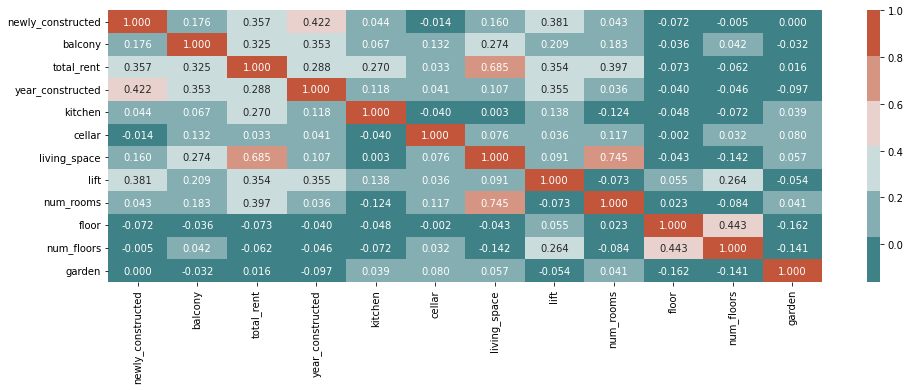

In [11]:
# Calculate a correlation matrix and show the heatmap to find out strong correlations between the columns on our target value "total_rent".
# Before removing outliers.
corr = df.corr ()
figure(figsize = (16,5))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt='.3f', cmap=sns.diverging_palette(200,20))

<AxesSubplot:>

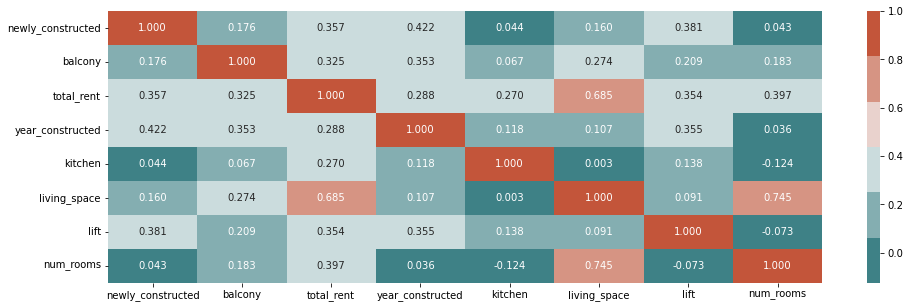

In [12]:
# Remove columns where the absolute correlation is smaller than 0.2. 
# We decided to exclude columns that doesn't have a relevant impact on the target value "total_rent". 
# That chosen threshold of 0,2 is not sophisticated but rather specified by instict.

corr_matrix = df.corr().abs()
corr_columns = corr_matrix['total_rent']
to_drop = []

for column, value in corr_columns.items():
    if value < 0.2:
      to_drop.append(column)

df.drop(to_drop, axis=1, inplace=True)

# Show correlation matrix after removing outliers.
corr = df.corr ()
figure(figsize = (16,5))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt='.3f', cmap=sns.diverging_palette(200,20))

<AxesSubplot:xlabel='total_rent', ylabel='state'>

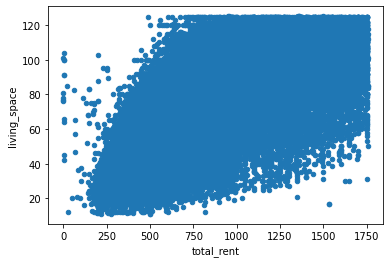

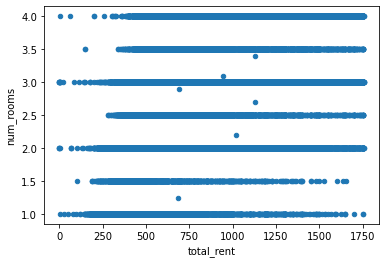

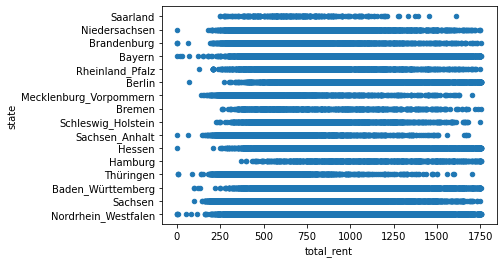

In [13]:
# Show scatterplots for getting a rough impression of correlations and identifying possible outliers.

df.plot(kind='scatter', x='total_rent', y='living_space')
df.plot(kind='scatter', x='total_rent', y='num_rooms')
df.plot(kind='scatter', x='total_rent', y='state')

### Feature Selection

In [14]:
# Remove irrelevant non-numerical columns after the calculation of correlation
df.drop(columns=['heating_type',
                 'firing_types',
                 'house_number',
                 'condition',
                 'street',
                 'type_of_flat',
                 'city',
                 'village'], inplace=True)

In [15]:
df

,state,newly_constructed,balcony,total_rent,year_constructed,kitchen,living_space,lift,num_rooms
0,Nordrhein_Westfalen,False,False,840.00,1965.0,False,86.00,False,4.0
2,Sachsen,True,True,1300.00,2019.0,False,83.80,True,3.0
8,Baden_Württemberg,False,False,690.00,1970.0,True,53.00,False,2.0
13,Nordrhein_Westfalen,False,False,1150.00,1951.0,False,123.44,False,4.0
14,Nordrhein_Westfalen,True,True,1320.65,2018.0,False,87.00,True,3.0
...,...,...,...,...,...,...,...,...,...
268838,Sachsen_Anhalt,False,True,514.50,1997.0,False,55.00,False,2.0
268840,Hessen,False,True,1479.64,2016.0,True,89.67,True,3.0
268843,Sachsen,False,True,368.00,1930.0,False,55.00,False,2.0
268846,Hessen,False,True,1150.00,1983.0,True,115.00,False,3.5


### Handling Categorical Data - One Hot Encoding

In [16]:
# convert categorial variable "state" into individual columns with dummy variables 0 and 1 so that this information can be used as input variable for the model.
df = pd.get_dummies(df, columns=["state"])

In [17]:
# reset the index so that lines are count from 0 upwards
df = df.reset_index(drop=True)

## Machine Learning Model

### Validation split

In [18]:
#assign the data to x (input variables) and y (the targetvariable "total_rent")
x = df.drop(['total_rent'], axis=1)
y = df['total_rent']

In [19]:
#data splitting so that 80% of the data is for training the model and 20% is for testing the errors in predictions
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

### Feature Scaling & Building Models

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import sklearn.metrics as metrics
!pip install xgboost



In [21]:
from sklearn import preprocessing

d = preprocessing.normalize(df)
scaled_df = pd.DataFrame(d)
scaled_df.head()

#building linear regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)

#building random forest model
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=2, random_state=42)
rf.fit(x_train, y_train)

pipeline1 = Pipeline([
    ("Linear Regression", LinearRegression())
])

pipeline2 = Pipeline([
    ("Scaling", StandardScaler()),
    ("Linear Regression", LinearRegression())
])

pipeline3 = Pipeline([
    ("Scaling", StandardScaler()),
    ("Random Forest", RandomForestRegressor())
])


pipeline1.fit(x_train, y_train)
pipeline2.fit(x_train, y_train)
pipeline3.fit(x_train, y_train)

y_pred1 = pipeline1.predict(x_test)
y_pred2 = pipeline2.predict(x_test)
y_pred3 = pipeline3.predict(x_test)

print('Pipeline 1 Mean Absolute Error: ', mean_absolute_error(y_pred1, y_test))
print('Pipeline 1 Score', pipeline1.score(x_test, y_test))

print('Pipeline 2 Mean Absolute Error: ', mean_absolute_error(y_pred2, y_test))
print('Pipeline 2 Score', pipeline2.score(x_test, y_test))

print('Pipeline 3 Mean Absolute Error: ', mean_absolute_error(y_pred3, y_test))
print('Pipeline 3 Score', pipeline3.score(x_test, y_test))


Pipeline 1 Mean Absolute Error:  123.27681445622544
Pipeline 1 Score 0.7438363241823864
Pipeline 2 Mean Absolute Error:  123.28269926694013
Pipeline 2 Score 0.743862341274946
Pipeline 3 Mean Absolute Error:  114.57649616613641
Pipeline 3 Score 0.7524873906831872


In [22]:
#Test another model: XGBoost
from sklearn.metrics import mean_absolute_error

#building XGBoost model
import xgboost
xgb_r = xgboost.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 42)
xgb_r.fit(x_train, y_train)
 
# Predict the model
pred = xgb_r.predict(x_test)
print('XGBoost Mean Absolute Error:' , mean_absolute_error(pred, y_test))



[22:25:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Mean Absolute Error: 115.78645292339557


### Safe the Model

In [23]:
# safe the model to use it in the streamlit app
import pickle

pickle.dump(pipeline3, open('final_model.sav', 'wb'))